## Time to get your hands dirty.  The transient Universe

Time-domain astronomy is one of the new frontiers of the field. Example of transient phenomena include:

1. Tidal distruption events.
2. Sudden flares of active galactic nuclei
3. Supernovae.

### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!***


1) Read in `solutions/transient.npy`. This is a (10 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

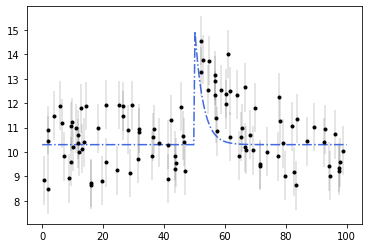

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy 

path = '../../solutions/transient.npy'
file = np.load(path)

import pandas as pd

df = pd.DataFrame(file, columns=['t','f','err_f'])
params = [50,-1,5,10.3]

True_BM = lambda t, P : np.where(t<P[0], P[3], P[3]+P[2]*np.exp(-np.exp(P[1])*(t-P[0])))

plt.errorbar(x=df['t'], y=df['f'], yerr=df['err_f'], fmt='.k', lw=0.2)
t = df.iloc[:,0].to_numpy()
t = np.linspace(0,100,250)
plt.plot(t, True_BM(t, params), c='royalblue', ls='-.')

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

In [64]:
from scipy.stats import norm

Burst_Model = lambda t, P : np.where(t<P[0], P[3], P[3]+P[2]*np.exp(-np.exp(P[1])*(t-P[0])))

def logLikelihood(params,data):
    t,f,err_f = data
    model_f = Burst_Model(t,params)
#   logpdfs = np.array([norm(y,sy).logpdf for x, y, sy in zip(t, model_f, err_f)] )
    logL = -0.5*np.sum( (f-model_f)**2 / err_f**2 )
#   logL = np.sum(logpdfs,axis=0)
    return logL

data = np.array([df['t'], df['f'], df['err_f']])


3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

In [65]:
import emcee

t0_range = [40,60]
loga_range = [-5,5]
A_range = [0,20]
b_range = [5,20]

Ranges = np.array([t0_range,loga_range,A_range,b_range])

def Prior(params):
    t0, loga, A, b = params
    check = lambda p, I : np.diff(I) if I[0] <= p <= I[1] else 0
    
    return np.prod([check(p,I) for p,I in zip(params,Ranges)])

def logPrior(params):
    y = Prior(params)
    if y == 0 : return -np.inf
    return np.log(y)

def logPosterior(params, data):
    #print(logLikelihood(data,params), logPrior(params))
    return logPrior(params) + logLikelihood(params,data)

In [66]:
import warnings
warnings.filterwarnings("ignore")

# number of parameters in the model
ndim = 4
# number of MCMC walkers
N = 20
nwalkers = N
# "burn-in" period to let chains stabilize
burn = 1000  
# number of MCMC steps to take **for each walker**
nsteps = 10000  

# initialize theta 
np.random.seed(0)
starting_guesses = np.array(params) + 1.5*np.random.random((nwalkers, ndim))*np.random.choice([-1,1])

print('starting mcmc')
# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=[data])
sampler.run_mcmc(starting_guesses, nsteps)
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)
print("done")

starting mcmc
done


4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

(1000.0, 10000.0)

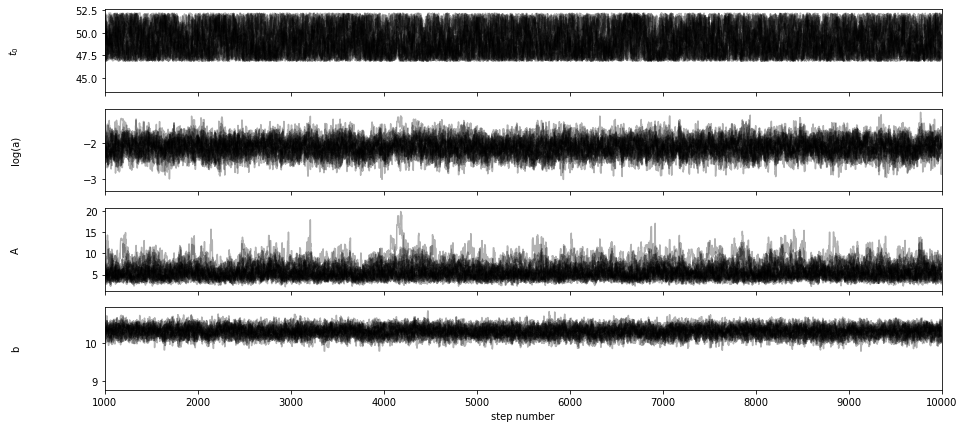

In [67]:
fig, axes = plt.subplots(4, figsize=(15, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$t_{0}$","log(a)","A","b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
axes[-1].set_xlim([1000,None])

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

[73.54916026 64.954445   78.08692589 55.43697502]
(2460, 4)


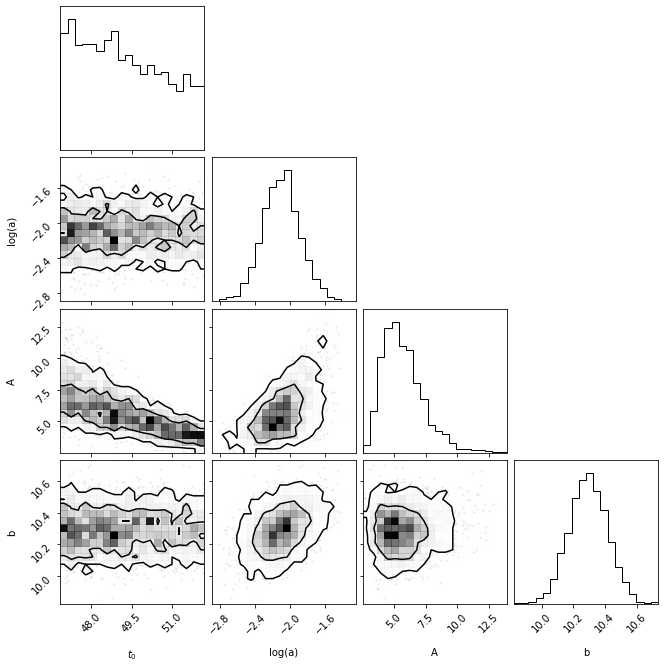

In [68]:
tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=5*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

import corner
fig = corner.corner( flat_samples, labels=labels, levels=[0.68,0.95] )

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

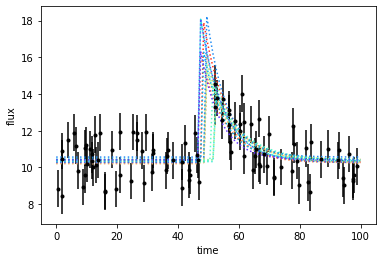

In [69]:
mySize = 15
chosen_samples= flat_samples[np.random.choice(len(flat_samples),size=mySize)]

import seaborn as sns
colors = sns.color_palette('rainbow_r', n_colors=mySize)
t=np.linspace(0,100,100)
i=0
for params in chosen_samples:
    f = Burst_Model(t,params)
    plt.plot(t,f,alpha=1, c=colors[i], ls=':')
    i+=1

_ = plt.errorbar(df['t'],df['f'],yerr=df['err_f'],fmt='.k')
_ = plt.xlabel("time")
_ = plt.ylabel("flux")

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

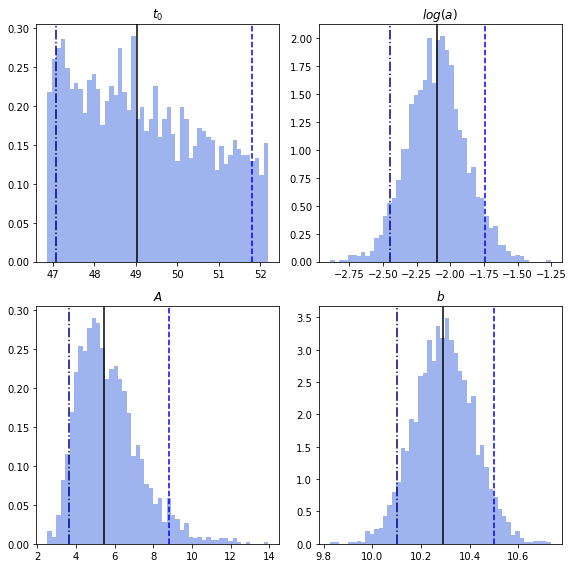

In [70]:
approx = lambda qty, n : np.around(qty,n)
decimals = 2

medians = [np.median(flat_samples[:,i]) for i in range(4)]
medians = approx(medians,decimals)

q = lambda sample, quantile : np.percentile(a=np.sort(sample), q=quantile)
low_q = [q( flat_samples[:,i], 5) for i in range(4)]
low_q = approx(low_q,decimals)

high_q = [q( flat_samples[:,i], 95) for i in range(4)]
high_q = approx(high_q,decimals)

from IPython.display import display, Latex
header = [r'$t_{0}$', r'$log(a)$', r'$A$', r'$b$']
for i in range(4):
    tag = header[i] + ' $=' + str(medians[i]) + r'^{+'+ str(high_q[i]) +r'}_{-'+ str(low_q[i]) + r'}$'
    display(Latex(tag))
    
fig, axs = plt.subplots(2,2, figsize=(8,8))
ax = axs.ravel()
for i in range(4):
    ax[i].hist(flat_samples[:,i], color='royalblue', alpha=0.5, bins=50, density=True)
    ax[i].axvline(medians[i], c='k', ls='-')
    ax[i].axvline(low_q[i], c='navy', ls='-.')
    ax[i].axvline(high_q[i], c='blue', ls='--')
    ax[i].set_title(header[i])
fig.tight_layout()

8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

5658it [00:07, 718.54it/s, +500 | bound: 20 | nc: 1 | ncall: 32880 | eff(%): 18.729 | loglstar:   -inf < -48.758 <    inf | logz: -59.297 +/-  0.199 | dlogz:  0.001 >  0.509]


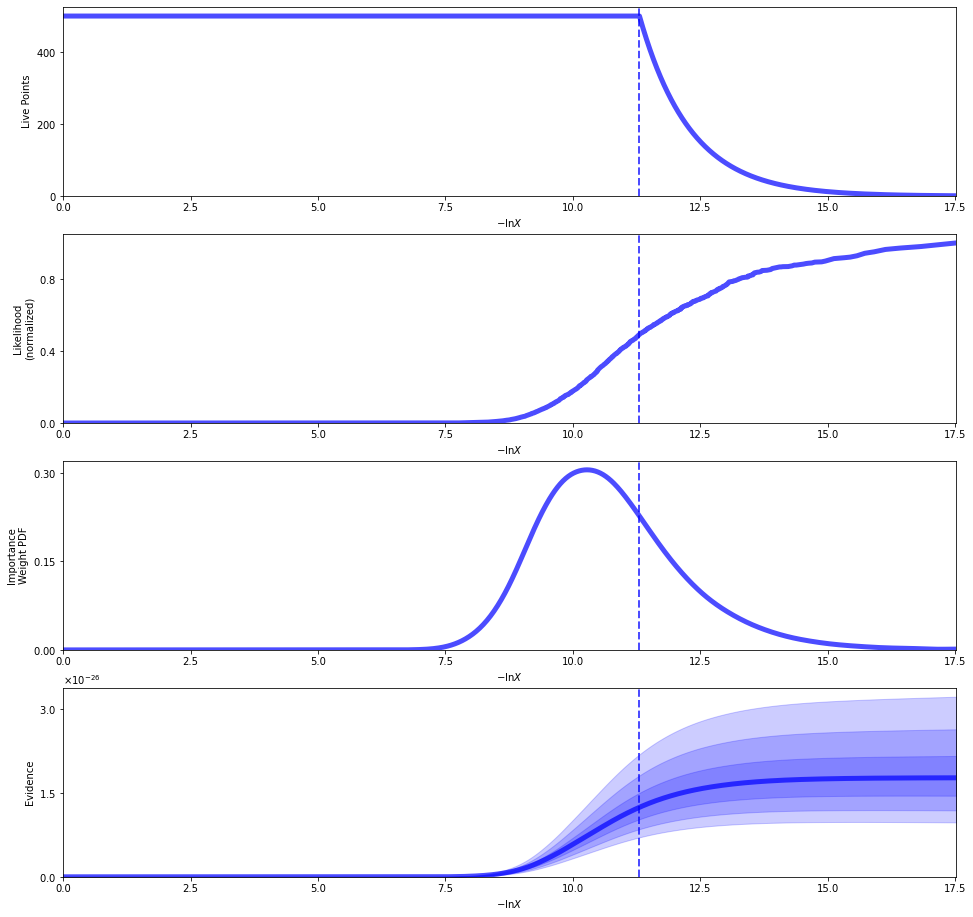

In [87]:
import dynesty

ndim = 4

# Define our uniform prior.
def ptform(u):
    # u is a random number between 0 and 1
    # u è un vettore, di random number tra 0 ed 1
    # u ha dimensione pari a ndim
    
    #my_u = u*np.array([np.diff(I)[0] for I in Ranges])+np.array([low for low in Ranges[:,0]])
    
    my_u = np.array([np.mean(I) for I in Ranges])+0.5*(2*u-1)*np.array([np.diff(I)[0] for I in Ranges])
    return my_u

sampler = dynesty.NestedSampler(logLikelihood, ptform, ndim, logl_args=[data])
sampler.run_nested()
sresults = sampler.results

from dynesty import plotting as dyplot
rfig, raxes = dyplot.runplot(sresults)

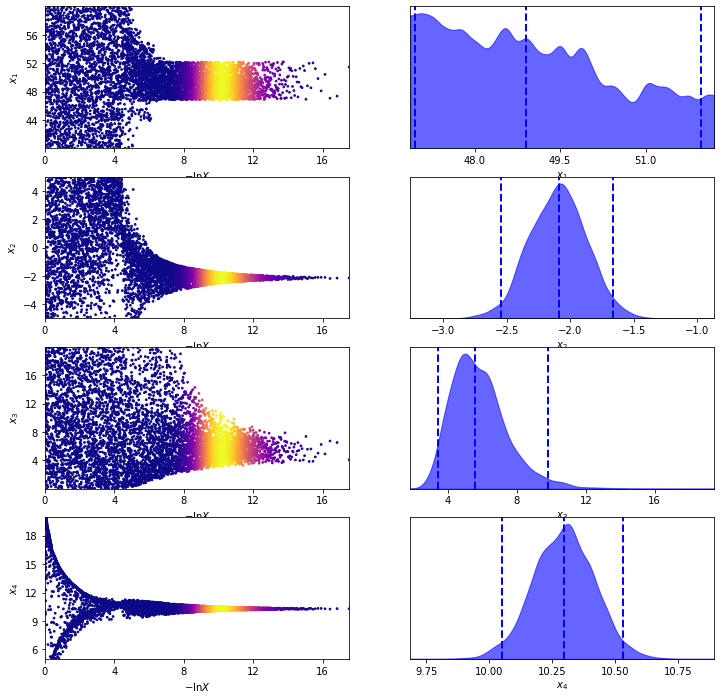

In [88]:
tfig, taxes = dyplot.traceplot(sresults)

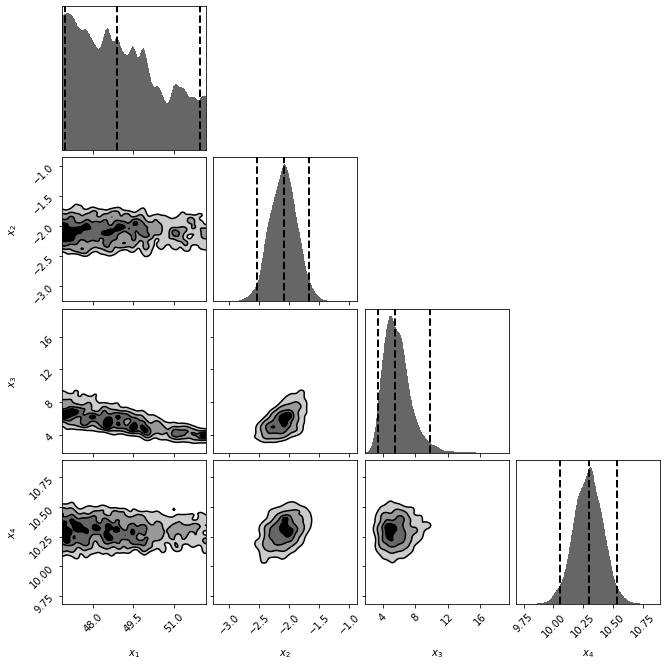

In [89]:
cfig, caxes = dyplot.cornerplot(sresults)

68% parameter credible regions are:
 [[47.446481810307105, 50.85384785190824], [-2.3244613929847917, -1.8720591893380762], [4.287273978255746, 7.261832025174717], [10.179041523761658, 10.413243747094063]]

Mean and covariance of parameters are: [49.06857058 -2.0958046   5.82560325 10.29527229]
[[ 2.16371577 -0.00633729 -1.5647942  -0.00627669]
 [-0.00633729  0.04996841  0.21752592  0.01038965]
 [-1.5647942   0.21752592  2.70963853  0.01634103]
 [-0.00627669  0.01038965  0.01634103  0.01436248]]


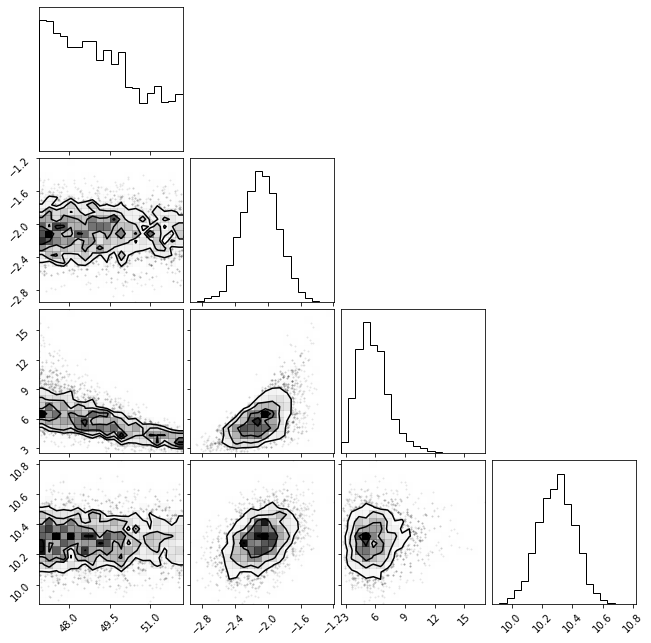

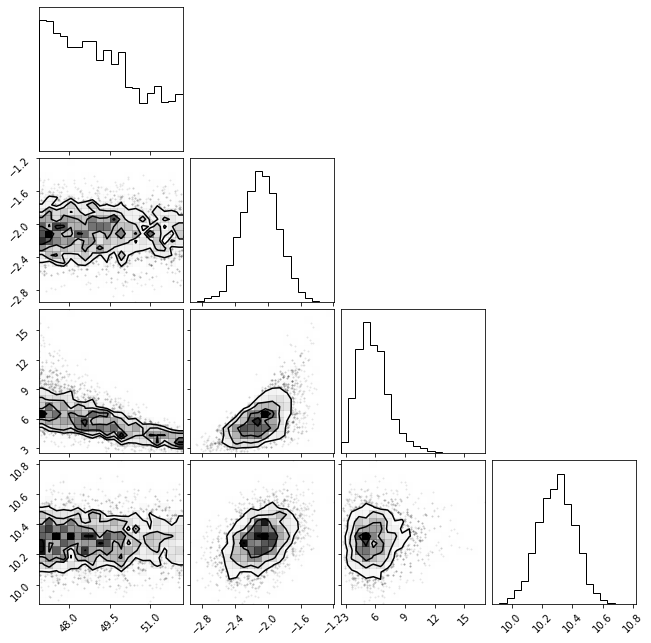

In [90]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(sresults)

corner.corner(samples_equal)

9) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

4346it [00:06, 674.06it/s, +500 | bound: 9 | nc: 1 | ncall: 24977 | eff(%): 19.402 | loglstar:   -inf < -337.753 <    inf | logz: -345.568 +/-  0.164 | dlogz:  0.001 >  0.509]


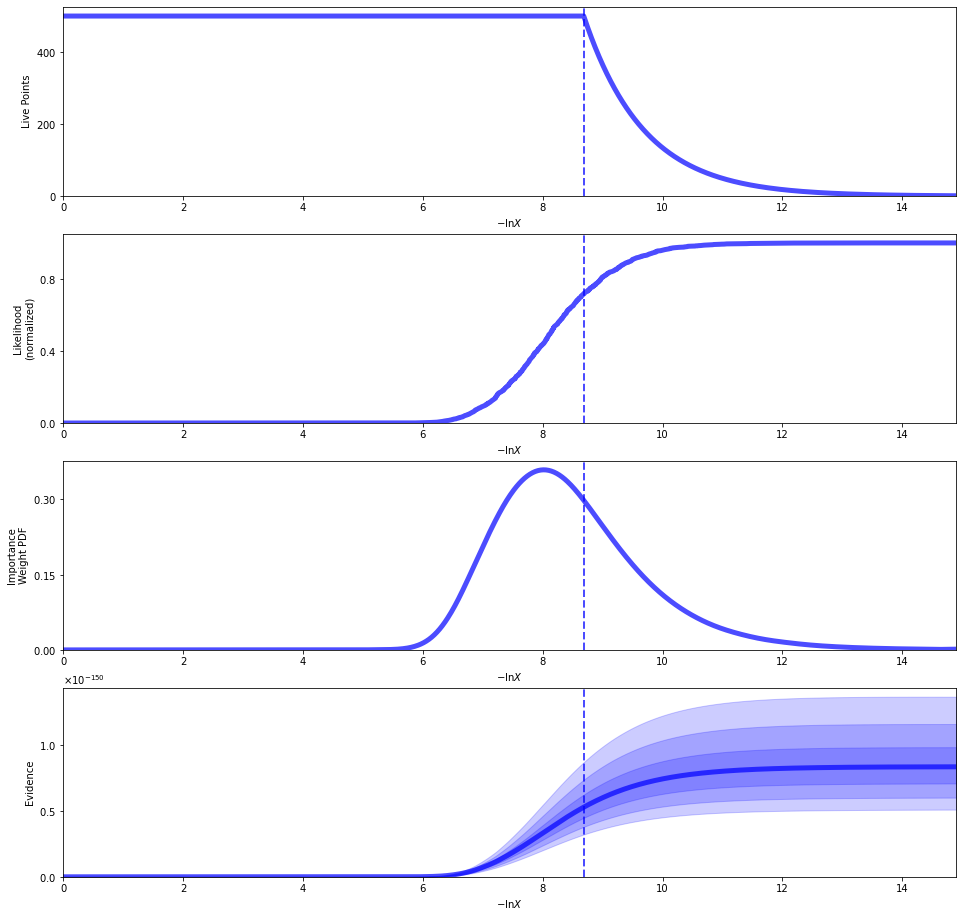

In [91]:
Gauss_Model = lambda t, P : P[3] + P[2]*np.exp(-( (t-P[1])**2 ) / ( 2*P[1]**2 ) )

def logGaussLikelihood(params, data):
    t,f,err_f = data[:]
    f_model = Gauss_Model(t,params)
    
    q = lambda f, f_model, err_f : -0.5*(f-f_model)**2 / err_f**2
    
    Q = np.sum( q(f,f_model,err_f) ) - np.sum( np.sqrt(2*np.pi*err_f**2) )
    return Q

t0_range = [40,60]
sigma_range = [0,10]
A_range = [0,20]
b_range = [5,20]

GaussRanges = np.array([t0_range,sigma_range,A_range,b_range])
"""
def GaussPrior(params):
    t0, sigma, A, b = params
    check = lambda p, I : np.diff(I) if I[0] <= p <= I[1] else 0
    
    return np.prod([check(p,I) for p,I in zip(params,GaussRanges)])

def logGaussPrior(params):
    y = Prior(params)
    if y == 0 : return -np.inf
    return np.log(y)

def logGaussPosterior(params, data):
    #print(logLikelihood(data,params), logPrior(params))
    return logPrior(params) + logGaussLikelihood(params,data)

# number of parameters in the model
ndim = 4
# number of MCMC walkers
N = 20
nwalkers = N
# "burn-in" period to let chains stabilize
burn = 1000  
# number of MCMC steps to take **for each walker**
nsteps = 10000  

# initialize theta 
np.random.seed(0)
starting_guesses = np.array(params) + 1.5*np.random.random((nwalkers, ndim))*np.random.choice([-1,1])

print('starting mcmc')
# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logGaussPosterior, args=[data])
sampler.run_mcmc(starting_guesses, nsteps)
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)
print("done")

fig, axes = plt.subplots(4, figsize=(15, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$t_{0}$","$\sigma_{W}$","A","b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
axes[-1].set_xlim([1000,None])

tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=5*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

import corner
fig = corner.corner( flat_samples, labels=labels, levels=[0.68,0.95] )
"""

ndim = 4

# Define our uniform prior.
def Gaussptform(u):
    my_u = np.array([np.mean(I) for I in GaussRanges])+0.5*(2*u-1)*np.array([np.diff(I)[0] for I in GaussRanges])
    return my_u

sampler = dynesty.NestedSampler(logGaussLikelihood, Gaussptform, ndim, logl_args=[data])
sampler.run_nested()
sresults = sampler.results

from dynesty import plotting as dyplot
rfig, raxes = dyplot.runplot(sresults)

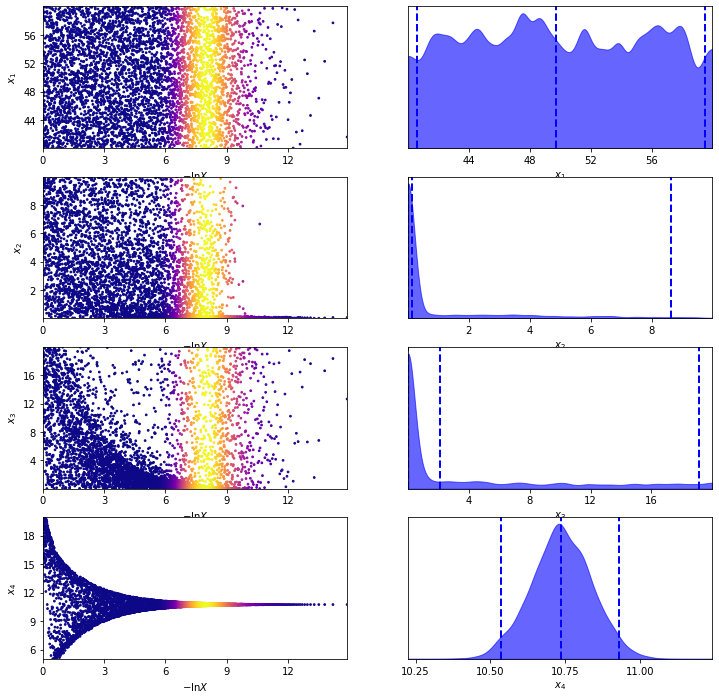

In [92]:
tfig, taxes = dyplot.traceplot(sresults)

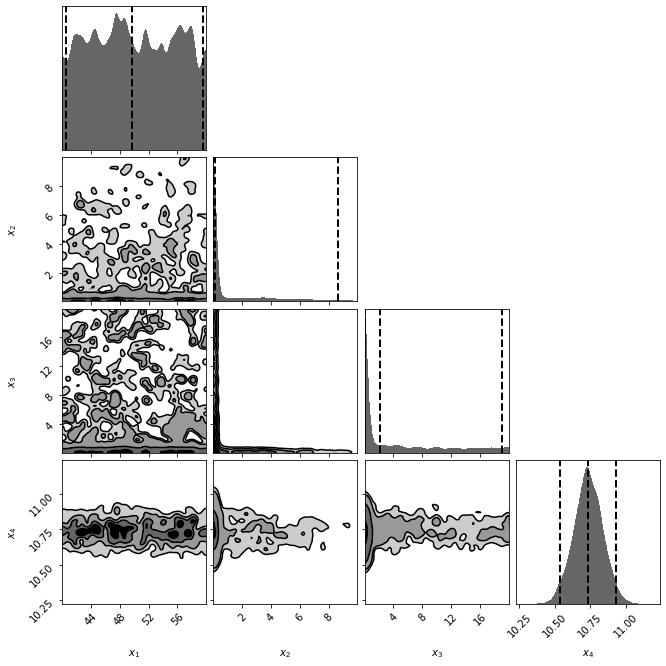

In [93]:
cfig, caxes = dyplot.cornerplot(sresults)

10) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?